# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [14]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
DEVICE = 'cuda:0'
NDIM = 3 # number of parameters
NBINS = 1000

In [16]:
SIGMA = 0.1
def model(z, w = 0.03):
    grid = np.linspace(0, 1, 32, 32)
    X, Y = np.meshgrid(grid, grid)
    x1, y1, r = z[0], z[1], z[2]*0.5
    R1 = ((X-x1)**2 + (Y-y1)**2)**0.5
    mu = np.exp(-(R1-r)**2/w**2/2)
    x = mu
    return x

def noisemodel(x, z = None):
    n = np.random.randn(*x.shape)*SIGMA  #*noiselevel
    return x + n

In [17]:
# Convolutional network as HEAD of inference network

class Head(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, 3)
        self.conv2 = torch.nn.Conv2d(10, 20, 3)
        self.conv3 = torch.nn.Conv2d(20, 40, 3)
        self.pool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        nbatch = len(x)
        
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

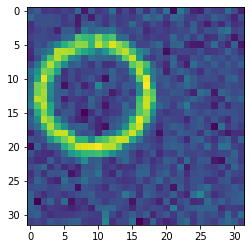

In [18]:
z0 = np.array([0.3, 0.4, .5])
x0 = noisemodel(model(z0))
plt.imshow(x0);
plt.savefig('Ringx0.png',dpi=300)

In [19]:
ds = swyft.DataStoreZarr("/home/aecole/swyft/notebooks/ring3.zarr")
ds.init(zdim = 3, xdim = (32, 32))

Creating empty datastore: /home/aecole/swyft/notebooks/ring3.zarr
...don't forget to run `init` to set up storage parameters.
Datastore initialized.


In [20]:
sw_list = []

for i_round in range(5):
    parent = None if len(sw_list) == 0 else sw_list[-1]
    sw = swyft.SWYFT(x0, zdim = 3, device = DEVICE, head = Head, datastore = ds, nsamples = 2000, noisemodel = noisemodel, parent = parent)
    sw_list.append(sw)
    
    if sw.requires_sim():
        for i in ds.require_sim():
            z = ds.z[i]
            x = model(z)
            ds.add_sim(i, x)
            
    sw.train1d(max_epochs = 100, nbatch = 16)

Constrained posterior area: 1.0
Adding 2025 new samples. Run simulator!
Number of output features: 160
Start training
LR iteration 0
Total epochs: 23
Validation losses: [6.641327306628227, 5.945209547877312, 5.657461330294609, 5.7459336668252945, 5.3894252851605415, 5.18451489508152, 4.819754965603352, 4.957694917917252, 4.6351781487464905, 4.5771060809493065, 4.383375629782677, 4.44465745985508, 4.378941528499126, 4.510425910353661, 4.750698447227478, 4.309231713414192, 4.540313094854355, 4.515660706907511, 4.288807798177004, 4.118305593729019, 4.5324778109788895, 4.725856311619282, 4.256278906017542]
LR iteration 1
Total epochs: 7
Validation losses: [3.8327797055244446, 3.8181751184165478, 3.8773783687502146, 3.7423786744475365, 3.956864323467016, 3.967580109834671, 3.9116452895104885]
LR iteration 2
Total epochs: 4
Validation losses: [3.839830879122019, 3.8595507964491844, 3.866153344511986, 3.883352778851986]
Constrained posterior area: 0.056648403
Adding 1885 new samples. Run simu

In [21]:
ds.__len__()

9168

In [22]:
#sw_list = []
for i_round in range(1):
    parent = None if len(sw_list) == 0 else sw_list[-1]
    sw = swyft.SWYFT(x0, zdim = 3, device = DEVICE, head = Head, datastore = ds, nsamples = 5000, noisemodel = noisemodel, parent = parent)
    sw_list.append(sw)
    
    if sw.requires_sim():
        for i in ds.require_sim():
            z = ds.z[i]
            x = model(z)
            ds.add_sim(i, x)
            
    sw.train1d(max_epochs = 100, nbatch = 16)

Constrained posterior area: 4.5630095e-06
Adding 3481 new samples. Run simulator!
Number of output features: 160
Start training
LR iteration 0
Total epochs: 15
Validation losses: [5.596390791237354, 4.555779829621315, 5.4488957822322845, 4.46058539301157, 4.018868885934353, 4.2534568309783936, 4.162096709012985, 4.014284200966358, 3.8847895860671997, 3.940632425248623, 3.9956718161702156, 3.8286949172616005, 3.901367411017418, 3.9779060408473015, 4.266022227704525]
LR iteration 1
Total epochs: 6
Validation losses: [3.564581476151943, 3.6120759174227715, 3.4103430435061455, 3.5772042088210583, 3.4670885130763054, 3.5009635984897614]
LR iteration 2
Total epochs: 7
Validation losses: [3.4699594751000404, 3.5293461605906487, 3.4622110202908516, 3.231684684753418, 3.4289800375699997, 3.3937515802681446, 3.3863517120480537]


In [23]:
grad = []
for i in range(0, NDIM):
    dz = np.zeros(NDIM)
    d = 0.001
    dz[i] += d
    g = (model(z0+dz) - model(z0))/d
    grad.append(g)

I = np.zeros((NDIM, NDIM))

for i in range(NDIM):
    for j in range(NDIM):
        I[i, j] = (grad[i]*grad[j]).sum()/SIGMA**2
        
Cov = np.linalg.inv(I)
err = np.diag(Cov)**0.5
print(err)

[0.00067007 0.00066999 0.00094704]


In [24]:
mn=[]
mn.append([0.30208,0.30208-0.00068,0.30208+0.00068])
mn.append([0.39988,0.39988-0.00066,0.39988+0.00066])
mn.append([0.49987,0.49987-0.00096,0.49987+0.00096])

In [40]:
torch.save(sw_list[-1].post1d,"oneRing1-Post.pt")

In [46]:
sw.net1d

Network(
  (head): Head(
    (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
    (conv3): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (legs): DenseLegs(
    (fc1): LinearWithChannel()
    (fc2): LinearWithChannel()
    (fc3): LinearWithChannel()
    (fc4): LinearWithChannel()
    (drop): Dropout(p=0.0, inplace=False)
  )
)

In [48]:
intervals=sw.get_intervals(sw.net1d)

In [49]:
print(intervals)

[[[0.29571295, 0.30765307]], [[0.39460394, 0.40602404]], [[0.4920349, 0.50786513]]]


1.0565721455828554 2.123645934536722
0.9445910236591472 1.9802961238787076
1.0302036648263706 2.050102813841035


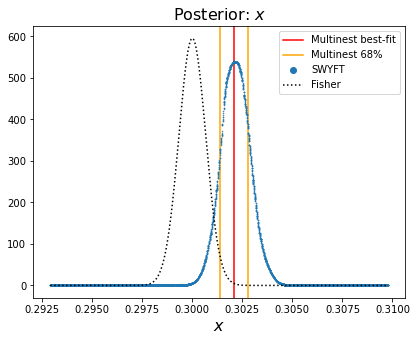

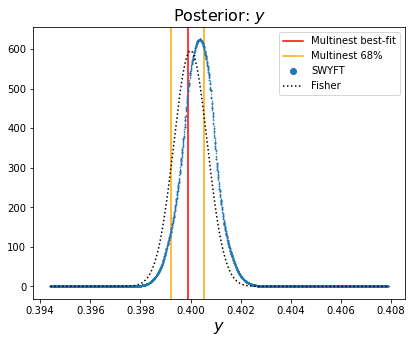

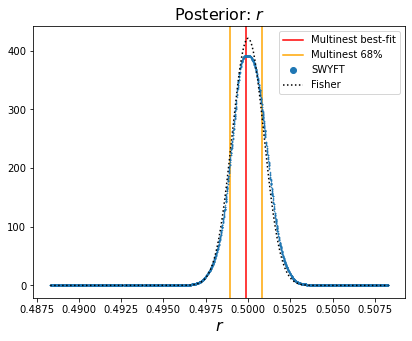

In [26]:
#plt.figure(figsize=(20, 5))
pList=["$x$",'$y$','$r$']
for i in range(3):
    plt.figure(figsize=(20/3,5))
    z, p = sw_list[-1].posterior(i)
    #plt.axvline(z0[i])
    plt.axvline(mn[i][0],color='red',label='Multinest best-fit')
    plt.axvline(mn[i][1],color='orange', label='Multinest 68%')
    plt.axvline(mn[i][2],color='orange')
    plt.plot(z, p,'o',markersize=0.5,label='SWYFT')
    plt.plot(z, stats.norm.pdf(z, z0[i], err[i]), 'k:',label='Fisher')
    plt.title('Posterior: '+pList[i],fontsize=16)
    plt.xlabel(pList[i],fontsize=16)
    lgnd=plt.legend()
    lgnd.legendHandles[2]._legmarker.set_markersize(6)
    s = swyft.get_stats(z, p)
    print(s['err68']/err[i], s['err95']/err[i])
    plt.savefig('Figs/RingImage'+str(i)+"-1.png",dpi=300)

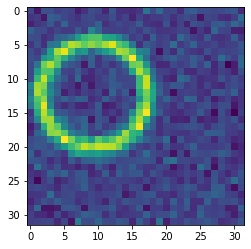

In [27]:
np.random.seed(26)
torch.manual_seed(26)
z1 = np.array([0.3+.00067007, 0.4-0.00066999, .5+0.00094704])
x1 = noisemodel(model(z1))
plt.imshow(x1)

In [28]:
sw2_list = []

for i_round in range(5):
    parent = None if len(sw2_list) == 0 else sw2_list[-1]
    sw2 = swyft.SWYFT(x1, zdim = 3, device = DEVICE, head = Head, datastore = ds, nsamples = 2000, noisemodel = noisemodel, parent = parent)
    sw2_list.append(sw2)
    
    if sw.requires_sim():
        for i in ds.require_sim():
            z = ds.z[i]
            x = model(z)
            ds.add_sim(i, x)
            
    sw2.train1d(max_epochs = 100, nbatch = 16)

Constrained posterior area: 1.0
No new simulator runs required.
Number of output features: 160
Start training
LR iteration 0
Total epochs: 17
Validation losses: [7.040027946233749, 6.089512288570404, 5.84215535223484, 5.608336493372917, 5.202537454664707, 5.115183666348457, 4.971550852060318, 4.769826367497444, 4.67406690120697, 4.808501273393631, 4.77360225468874, 4.53078269213438, 4.583206810057163, 4.308610051870346, 4.440698683261871, 4.533544547855854, 4.426535785198212]
LR iteration 1
Total epochs: 7
Validation losses: [3.8964258581399918, 3.87761390209198, 3.8381803780794144, 3.7673184871673584, 3.7703344225883484, 3.8535632267594337, 3.830115396529436]
LR iteration 2
Total epochs: 4
Validation losses: [3.7836256623268127, 3.7991369292140007, 3.8067652136087418, 3.8172979280352592]
Constrained posterior area: 0.1420121
Adding 1112 new samples. Run simulator!
Number of output features: 160
Start training
LR iteration 0
Total epochs: 10
Validation losses: [6.083947688341141, 4.309

In [37]:
1112+1339+1564+541+2091

6647

In [30]:
for i_round in range(1):
    parent = None if len(sw2_list) == 0 else sw2_list[-1]
    sw2 = swyft.SWYFT(x1, zdim = 3, device = DEVICE, head = Head, datastore = ds, nsamples = 5000, noisemodel = noisemodel, parent = parent)
    sw2_list.append(sw2)
    
    if sw.requires_sim():
        for i in ds.require_sim():
            z = ds.z[i]
            x = model(z)
            ds.add_sim(i, x)
            
    sw2.train1d(max_epochs = 100, nbatch = 16)

Constrained posterior area: 3.414595e-06
Adding 2091 new samples. Run simulator!
Number of output features: 160
Start training
LR iteration 0
Total epochs: 11
Validation losses: [7.427806228399277, 5.368574604392052, 4.683606386184692, 4.899202391505241, 4.73028289526701, 4.3856374099850655, 4.466781876981258, 4.10669656842947, 4.135811224579811, 4.234400078654289, 4.349173441529274]
LR iteration 1
Total epochs: 6
Validation losses: [4.049479819834232, 3.8969894722104073, 3.8383975699543953, 4.046811416745186, 3.9757430478930473, 3.913012832403183]
LR iteration 2
Total epochs: 4
Validation losses: [3.778691127896309, 3.787734843790531, 3.813281901180744, 3.835986912250519]


In [36]:
ds.__len__()

19296

In [38]:
19296-6647

12649

In [32]:
grad = []
for i in range(0, NDIM):
    dz = np.zeros(NDIM)
    d = 0.001
    dz[i] += d
    g = (model(z1+dz) - model(z1))/d
    grad.append(g)

I = np.zeros((NDIM, NDIM))

for i in range(NDIM):
    for j in range(NDIM):
        I[i, j] = (grad[i]*grad[j]).sum()/SIGMA**2
        
Cov = np.linalg.inv(I)
err2 = np.diag(Cov)**0.5
print(err2)

[0.00066944 0.00066931 0.00094611]


In [33]:
mn2=[]
mn2.append([0.30023 ,0.30023 + 0.00067,0.30023 - 0.00067])
mn2.append([0.39861 ,0.39861 + 0.00065,0.39861 - 0.00065])
mn2.append([0.50022 ,0.50022 + 0.00095,0.50022 - 0.00095])

In [39]:
torch.save(sw2_list[-1].post1d,"oneRing2-Post.pt")

1.1204060666451492 2.2584288295661086
1.1158073308913639 2.1233387627018074
1.0701981336531825 2.1345355451377706


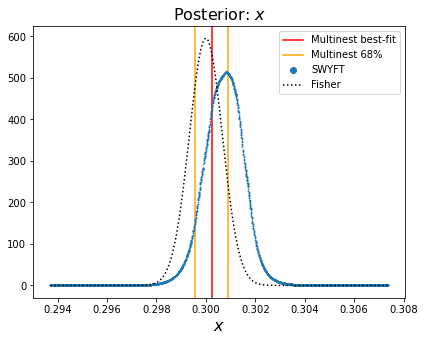

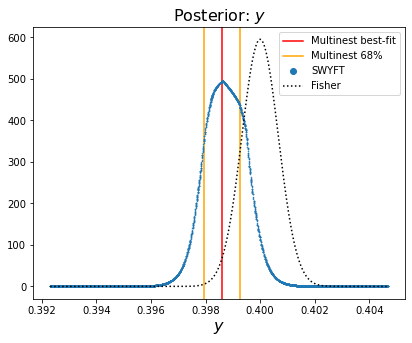

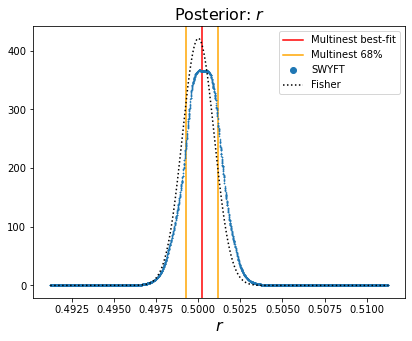

In [35]:
#plt.figure(figsize=(20, 5))
pList=["$x$",'$y$','$r$']
for i in range(3):
    plt.figure(figsize=(20/3,5))
    z, p = sw2_list[-1].posterior(i)
    #plt.axvline(z0[i])
    plt.axvline(mn2[i][0],color='red',label='Multinest best-fit')
    plt.axvline(mn2[i][1],color='orange')
    plt.axvline(mn2[i][2],color='orange',label='Multinest 68%')
    plt.plot(z, p,'o',markersize=0.5,label='SWYFT')
    plt.plot(z, stats.norm.pdf(z, z0[i], err[i]), 'k:',label='Fisher')
    plt.title('Posterior: '+pList[i],fontsize=16)
    plt.xlabel(pList[i],fontsize=16)
    lgnd=plt.legend()
    lgnd.legendHandles[2]._legmarker.set_markersize(6)
    s = swyft.get_stats(z, p)
    print(s['err68']/err[i], s['err95']/err[i])
    plt.savefig('Figs/RingImage'+str(i)+"-2.png",dpi=300)